In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os


data = []
labels = []
IMG_SIZE = 150
for i in os.listdir('/kaggle/input/nn23-sports-image-classification/Train'):
    img = cv.imread('/kaggle/input/nn23-sports-image-classification/Train/'+i)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img = cv.resize(img,(IMG_SIZE,IMG_SIZE))
    data.append(img)
    labels.append(i.split('_')[0])

print(len(data))
print(labels[0])

1681
Yoga


# Preprocessing

In [62]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

le = LabelEncoder()
train_labels = le.fit_transform(labels)
train_labels = np_utils.to_categorical(train_labels, len(np.unique(train_labels)))

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(np.array(data), np.array(train_labels), test_size=0.20, random_state=42)

# normalize the data
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

print(len(trainX))
print(len(testX))

1344
337


# Data Augmentation

In [63]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
val_datagen = ImageDataGenerator()
train_gen = train_datagen.flow(trainX,trainY,batch_size=10)
val_gen = val_datagen.flow(testX,testY,batch_size=10)

# Model

In [66]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

model = Sequential()
l2 = tf.keras.regularizers.l2(0.0001)
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu', kernel_regularizer=l2))
model.add(Dropout(0.3))
model.add(Dense(6,activation='softmax'))

In [67]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_92 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_86 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_87 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_88 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 15, 15, 64)      

In [68]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

checkpoint = ModelCheckpoint('model.h5',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False,mode='auto',period=1)
early = EarlyStopping(monitor='val_loss',min_delta=0,patience=20,verbose=1,mode='auto')


hist = model.fit(train_gen,epochs=100,validation_data=val_gen,callbacks=[checkpoint,early])

Epoch 1/100
135/135 [==============================] - 30s 212ms/step - loss: 1.7378 - accuracy: 0.3051 - val_loss: 1.5858 - val_accuracy: 0.4214

Epoch 00001: val_loss improved from inf to 1.58583, saving model to model.h5
Epoch 2/100
135/135 [==============================] - 28s 212ms/step - loss: 1.4964 - accuracy: 0.4278 - val_loss: 1.4125 - val_accuracy: 0.4481

Epoch 00002: val_loss improved from 1.58583 to 1.41253, saving model to model.h5
Epoch 3/100
135/135 [==============================] - 28s 208ms/step - loss: 1.4295 - accuracy: 0.4658 - val_loss: 1.3685 - val_accuracy: 0.4926

Epoch 00003: val_loss improved from 1.41253 to 1.36847, saving model to model.h5
Epoch 4/100
135/135 [==============================] - 28s 209ms/step - loss: 1.3593 - accuracy: 0.5000 - val_loss: 1.3724 - val_accuracy: 0.4748

Epoch 00004: val_loss did not improve from 1.36847
Epoch 5/100
135/135 [==============================] - 28s 211ms/step - loss: 1.2906 - accuracy: 0.5089 - val_loss: 1.2553

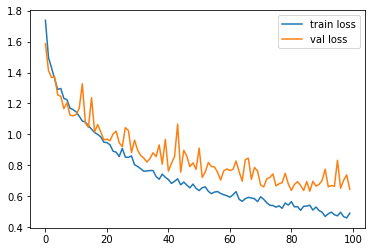

In [69]:
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# Evaluation

In [71]:
model.evaluate(testX,testY)

11/11 [==============================] - 1s 122ms/step - loss: 0.6448 - accuracy: 0.8101


[0.6448230743408203, 0.8100889921188354]

# Reading Test Data

In [72]:
test_data = []
for i in os.listdir('/kaggle/input/nn23-sports-image-classification/Test'):
    img = cv.imread('/kaggle/input/nn23-sports-image-classification/Test/'+i)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img = cv.resize(img,(IMG_SIZE,IMG_SIZE))
    test_data.append(np.array(img))
test_data = np.array(test_data)
test_data = test_data/255.0

print(len(test_data))

688


# Predictions

In [79]:
pred = model.predict(test_data)
pred = np.argmax(pred,axis=1)
df = pd.DataFrame({'image_name':os.listdir('/kaggle/input/nn23-sports-image-classification/Test'),'Label':pred})
df.to_csv('submission.csv',index=False)
df

,image_name,Label
0,623.jpg,2
1,208.jpg,5
2,473.jpg,1
3,333.jpg,1
4,537.jpg,1
...,...,...
683,364.jpg,3
684,90.jpg,1
685,599.jpg,2
686,25.jpg,4


In [11]:
model.save('model.h5')
import pickle
f = open('label_encoder.pkl', "wb")
f.write(pickle.dumps(le))
f.close()